In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from collections import OrderedDict
from matplotlib import rcParams

In [2]:
rcParams.update({'legend.fontsize': 'xx-large',
                 'axes.labelsize': 'xx-large',
                 'axes.titlesize':'xx-large',
                 'xtick.labelsize':'xx-large',
                 'ytick.labelsize':'xx-large'})

# P3 - Deterministic Optimization

In [3]:
coefficients_table = np.asarray([
    [-0.195 , 0.95],
    [-0.975 , 0.95],
    [-1.5955, 0.95],
    [-1.9114, 0.95]
])
pd.DataFrame(coefficients_table, index='exp_0 exp_1 exp_2 exp_3'.split(), columns='c_0 c_1'.split())

,c_0,c_1
exp_0,-0.1950,0.95
exp_1,-0.9750,0.95
exp_2,-1.5955,0.95
exp_3,-1.9114,0.95


## a) Implement the subsystems 'source'.

### Version 1 (using difference equation for x(n), source is assumed as an IIR filter):

In [4]:
def apply_source_model(u, coefficients):
    x = np.pad(u, pad_width=((coefficients.shape[0], 0),), mode='constant')
    for out_index in range(coefficients.shape[0], x.shape[0]):
        for coefficient_index in range(coefficients.shape[0]):
            x[out_index] -= coefficients[coefficient_index] * x[out_index-coefficient_index - 1]
    return x[coefficients.shape[0]:]

#### Test your implementation of the 'source':

In [5]:
test_signal = np.asarray([1., 2., 3., 4., 5.])
test_coefficients = np.asarray([3., -4.])
desired = np.asarray([1., -1., 10., -30., 135.])
actual = apply_source_model(test_signal, test_coefficients)
np.testing.assert_equal(actual, desired)

### Version 2 :

In [6]:
def apply_source_model(u, coefficients):
    return scipy.signal.lfilter([1.], np.pad(coefficients, ((1,0)), 'constant', constant_values=1.), u)

In [7]:
test_signal = np.asarray([1., 2., 3., 4., 5.])
test_coefficients = np.asarray([3., -4.])
desired = np.asarray([1., -1., 10., -30., 135.])
actual = apply_source_model(test_signal, test_coefficients)
np.testing.assert_equal(actual, desired)

### Implement the subsystems 'predictor'.

### Version 1 (using difference equation for y(n), predictor is assumed as an FIR filter):

In [8]:
def apply_predictor_model(x, coefficients):
    x = np.pad(x, pad_width=((coefficients.shape[0] - 1, 0),), mode='constant')
    y = np.zeros(x.shape)
    for index in range(coefficients.shape[0] - 1, x.shape[0]):
        for coefficient_index in range(0, coefficients.shape[0]):
            y[index] += coefficients[coefficient_index] * x[index - coefficient_index]
    return y[coefficients.shape[0] - 1:]

Test your implementation of the 'predictor':

In [9]:
test_signal = np.asarray([1., 2., 3., 4., 5.])
test_coefficients = np.asarray([1., 1.])
desired = np.asarray([1., 3., 5., 7., 9.])
actual = apply_predictor_model(test_signal, test_coefficients)
np.testing.assert_equal(actual, desired)

### Version 2:

Implement the subsystems 'predictor'.

In [10]:
def apply_predictor_model(x, coefficients):
    return scipy.signal.lfilter(coefficients, [1.], x)

Test your implementation of the 'predictor':

In [11]:
test_signal = np.asarray([1., 2., 3., 4., 5.])
test_coefficients = np.asarray([1., 1.])
desired = np.asarray([1., 3., 5., 7., 9.])
actual = apply_predictor_model(test_signal, test_coefficients)
np.testing.assert_equal(actual, desired)

## b) 
 Compute the variance $\sigma_u^2$ as a function of $\sigma_x^2$ and the source filter coefficients $a_1$ and $a_2$.

In [12]:
def get_sigma_u(sigma_x, coefficients):
    return sigma_x * np.sqrt(
    1
    + coefficients[1] * (coefficients[0] **2 / (1 + coefficients[1]) - coefficients[1])
    - coefficients[0] ** 2 / (1 + coefficients[1])
    )

## c) Gradient decent or Deterministic optimization

Perform the iterative gradient descent (Hint: To keep Python from ending up in an endless loop, always use a second stopping-criterion to exit the loop after e.g. $10000$ iterations.). Calculate the Eigenvalues, the Eigenvalue-Spread, the optimal stepsize $\mu_{opt}$ and the number of steps needed till the iteration stops for the different pairs of $a_1$ and $a_2$.

In [13]:
def get_auto_correlation_matrix(sigma_x, coefficients):
    return sigma_x ** 2 * np.asarray([
        [1., -coefficients[0] / (1+coefficients[1])],
        [-coefficients[0] / (1 + coefficients[1]), 1.]
    ])

In [37]:
def get_cross_correlation_vector(sigma_x, coefficients):
    return sigma_x ** 2 * np.asarray([
        [-coefficients[0] / (1 + coefficients[1])],
        [(coefficients[0] ** 2 - coefficients[1] ** 2 - coefficients[1]) / (1 + coefficients[1])]
    ])

In [38]:
def get_cost(sigma_x, w, p, R):
    return np.squeeze(sigma_x ** 2 - p.T @ w - w.T @ p + w.T @ R @ w)

In [51]:
mu = .3 #'mu_opt' #
N = 100000
K = 2
sigma_x = 1.
max_iterations = 10000000
eps = 1e-4
summary = []
for experiment_index in range(coefficients_table.shape[0]):
    source_coefficients = coefficients_table[experiment_index, :]
    sigma_u = get_sigma_u(sigma_x, source_coefficients) #sigma_x is equal to sigma_d bcz we want to predict at x(n+1)
                                                        #at next time instance and the variance stays same, bcz it is 
                                                        #static parameter
    u = np.random.normal(scale=sigma_u, size=(N,))    #input signal, with zero mean white of variance sigma_u
    x = apply_source_model(u, source_coefficients)    #putting to source model to get the output
    
    R = get_auto_correlation_matrix(sigma_x, source_coefficients)
    p = get_cross_correlation_vector(sigma_x, source_coefficients)
    
    eigenvalues, eigenvectors = np.linalg.eigh(R)               #using the fact that ACM R is a symmetric matrix
    eigenvalue_spread = np.max(eigenvalues) / np.min(eigenvalues)
    if mu == 'mu_opt':
        mu = 2 / (np.min(eigenvalues) + np.max(eigenvalues))    #formula for optimal filter coefficient
    
    J_history = list()
    v_history = list()
    w_history = list()
    
    w = np.zeros((K, 1))
    w_opt = -np.asarray(source_coefficients)[:, None]
    w_history.append(w)
    iteration = 0
    
    #deterministic optimization:
    
    while iteration < max_iterations and np.linalg.norm(w - w_opt) > eps: #np.linalg.norm() --> converge to the optimal filter coefficient
        J_history.append(get_cost(sigma_x, w, p, R))    #remembering cost0
        v_history.append(eigenvectors @ (w - w_opt))    #remembering coordinate transform error vector
        w = w + mu * (p - R @ w)                        #gradient update  w = w - mu * (-p + R @ w)
        w_history.append(w)
        iteration += 1
    y = apply_predictor_model(x, w.flatten())
    J_actual = np.mean((y[:-1] - x[1:]) ** 2)
    
    summary.append(OrderedDict(
        c_0=source_coefficients[0],
        c_1=source_coefficients[1],
        w_0=w[0, 0],
        w_1=w[1, 0],
        w_opt=w_opt,
        w_history=np.asarray(w_history),
        v_history=np.asarray(v_history),
        J_history=np.asarray(J_history),
        lambda_0=eigenvalues[0],
        lambda_1=eigenvalues[1],
        mu=mu,
        spread=eigenvalue_spread,
        J_theoretical=np.round(J_history[-1], 6),    #using cost function described above
        J_actual=np.round(J_actual, 6),              #calculates predicted value and mse from ground truth value
        steps=iteration,
        p=p,
        R=R
    ))

df = pd.DataFrame(summary)
df.reindex(columns='c_0 c_1 w_0 w_1 lambda_0 lambda_1 mu spread J_theoretical J_actual steps'.split())

,c_0,c_1,w_0,w_1,lambda_0,lambda_1,mu,spread,J_theoretical,J_actual,steps
0,-0.1950,0.95,0.194941,-0.949934,0.900000,1.100000,0.3,1.222222,0.096525,0.097609,29
1,-0.9750,0.95,0.974934,-0.949934,0.500000,1.500000,0.3,3.000000,0.073125,0.072986,59
2,-1.5955,0.95,1.595430,-0.949930,0.181795,1.818205,0.3,10.001410,0.032228,0.032241,175
3,-1.9114,0.95,1.911329,-0.949929,0.019795,1.980205,0.3,100.036269,0.003822,0.003816,1665


#### Discussion of the table:
-> channel coeefs and wiener coeffs are almost similar but negative version of it. 
-> lambda_0 is min eigen value and lambda_1 is max eigen value.
-> when eigen-value spread is larger, it needs more steps to converge.

# d)

Display the development of $\mathbf w(\kappa)$.

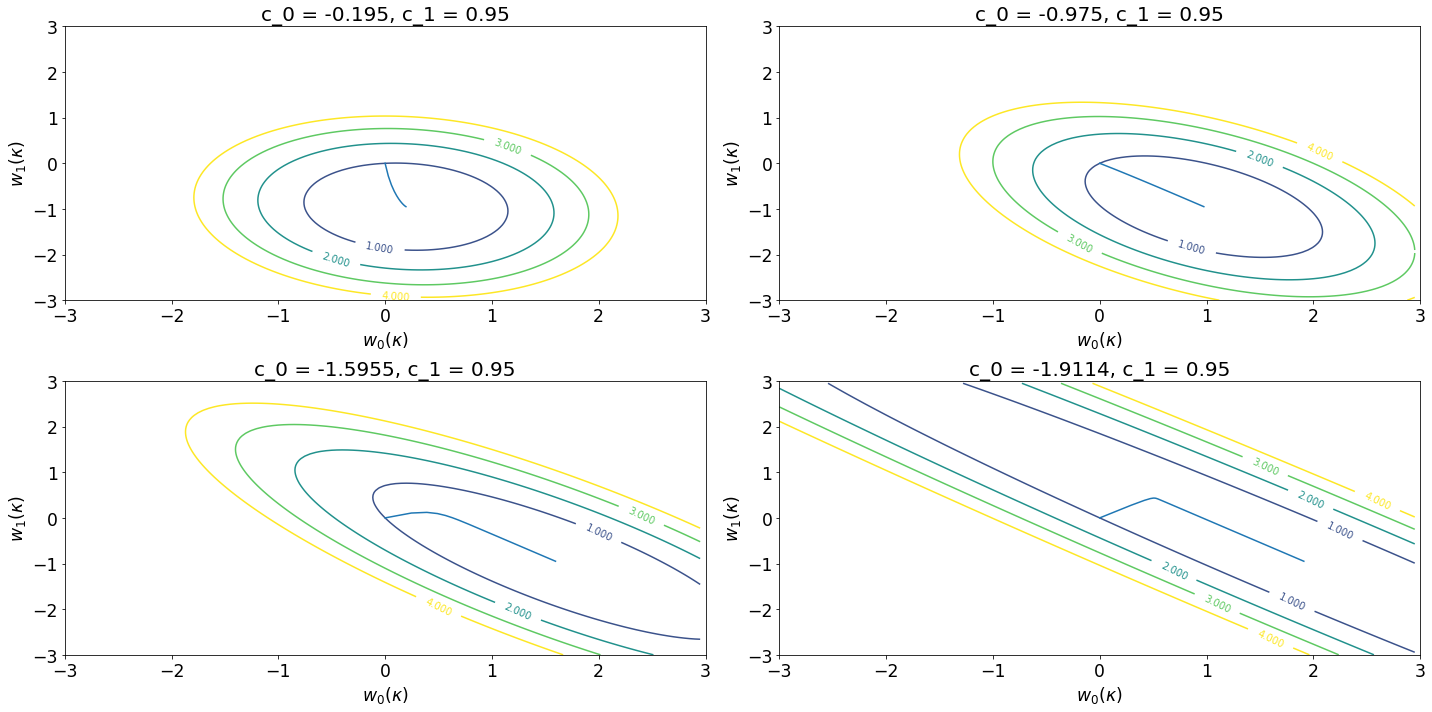

In [52]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for experiment, axis in zip(summary, axes.flatten()):
    delta = 0.05
    x = np.arange(-3, 3, delta)
    y = np.arange(-3, 3, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.empty_like(X)
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            Z[ix, iy] = get_cost(sigma_x, np.asarray([[X[ix, iy]], [Y[ix, iy]]]), experiment['p'], experiment['R'])
    axis.plot(experiment['w_history'][:, 0], experiment['w_history'][:, 1])
    CS = axis.contour(X, Y, Z, np.arange(5))
    plt.clabel(CS, inline=1, fontsize=10)
    axis.set_title(f'c_0 = {experiment["c_0"]}, c_1 = {experiment["c_1"]}', fontsize=20)
    axis.set_xlabel(r'$w_0(\kappa)$')
    axis.set_ylabel(r'$w_1(\kappa)$')
    axis.set_xticks(np.linspace(-3, 3, 7, endpoint=True))
    axis.set_yticks(np.linspace(-3, 3, 7, endpoint=True))
plt.tight_layout()

Display the development of $\boldsymbol \nu(\kappa)$.

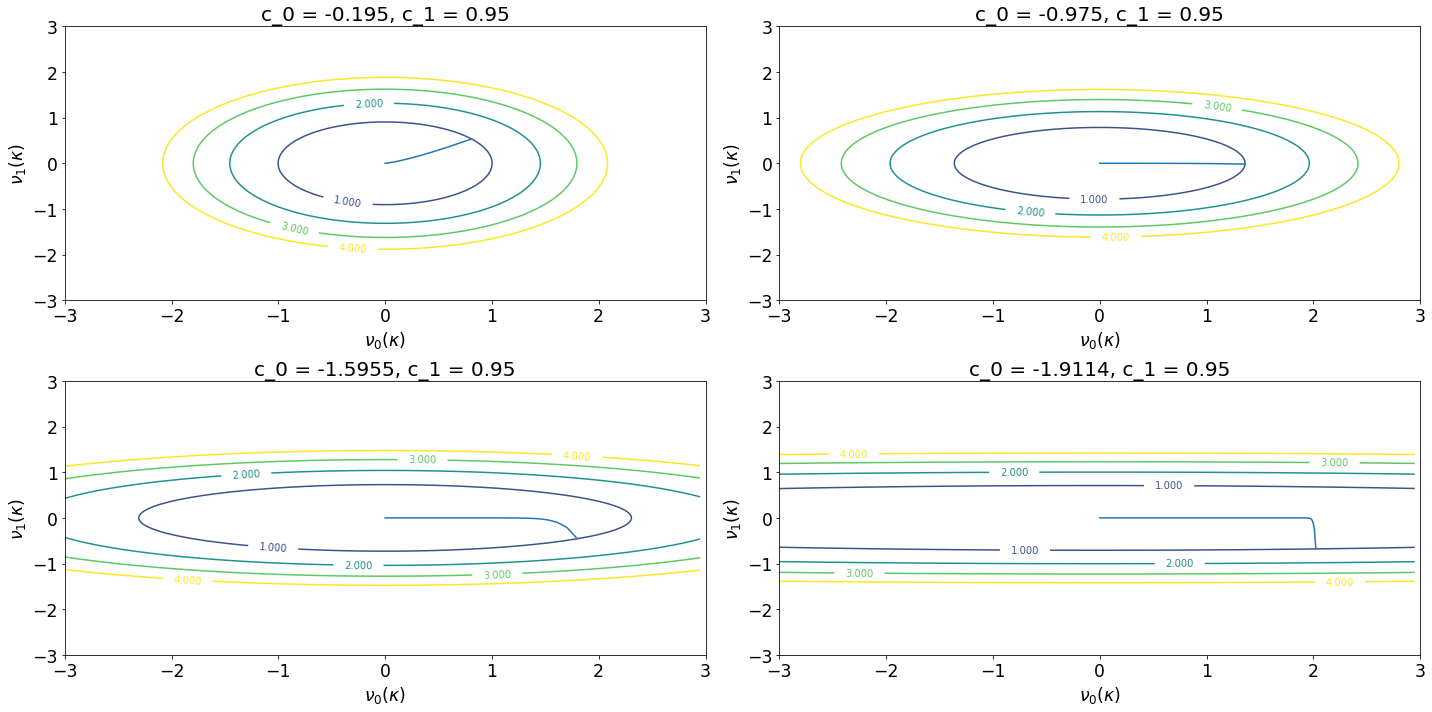

In [53]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for experiment, axis in zip(summary, axes.flatten()):
    delta = 0.05
    x = np.arange(-3, 3, delta)
    y = np.arange(-3, 3, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.empty_like(X)
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            Z[ix, iy] = get_cost(sigma_x, eigenvectors.T @ np.asarray([[X[ix, iy]], [Y[ix, iy]]]) + experiment['w_opt'], experiment['p'], experiment['R'])
    axis.plot(experiment['v_history'][:, 0], experiment['v_history'][:, 1])
    CS = axis.contour(X, Y, Z, np.arange(5))
    plt.clabel(CS, inline=1, fontsize=10)
    axis.set_title(f'c_0 = {experiment["c_0"]}, c_1 = {experiment["c_1"]}', fontsize=20)
    axis.set_xlabel(r'$\nu_0(\kappa)$')
    axis.set_ylabel(r'$\nu_1(\kappa)$')
    axis.set_xticks(np.linspace(-3, 3, 7, endpoint=True))
    axis.set_yticks(np.linspace(-3, 3, 7, endpoint=True))
plt.tight_layout()

# e)
Display the development of the cost function $J(\kappa)$.

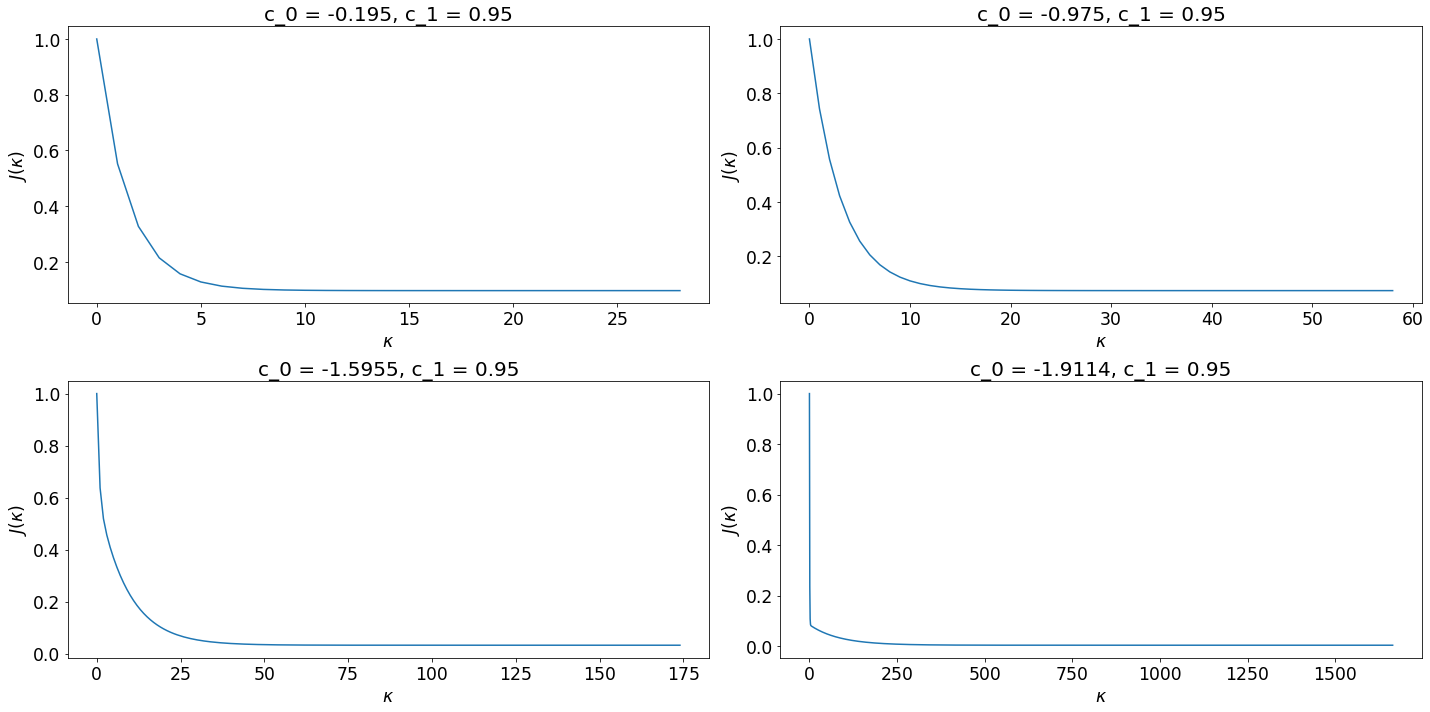

In [54]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for experiment, axis in zip(summary, axes.flatten()):
    axis.plot(experiment['J_history'])
    axis.set_title(f'c_0 = {experiment["c_0"]}, c_1 = {experiment["c_1"]}', fontsize=20)
    axis.set_xlabel(r'$\kappa$')
    axis.set_ylabel(r'$J(\kappa)$')
plt.tight_layout()

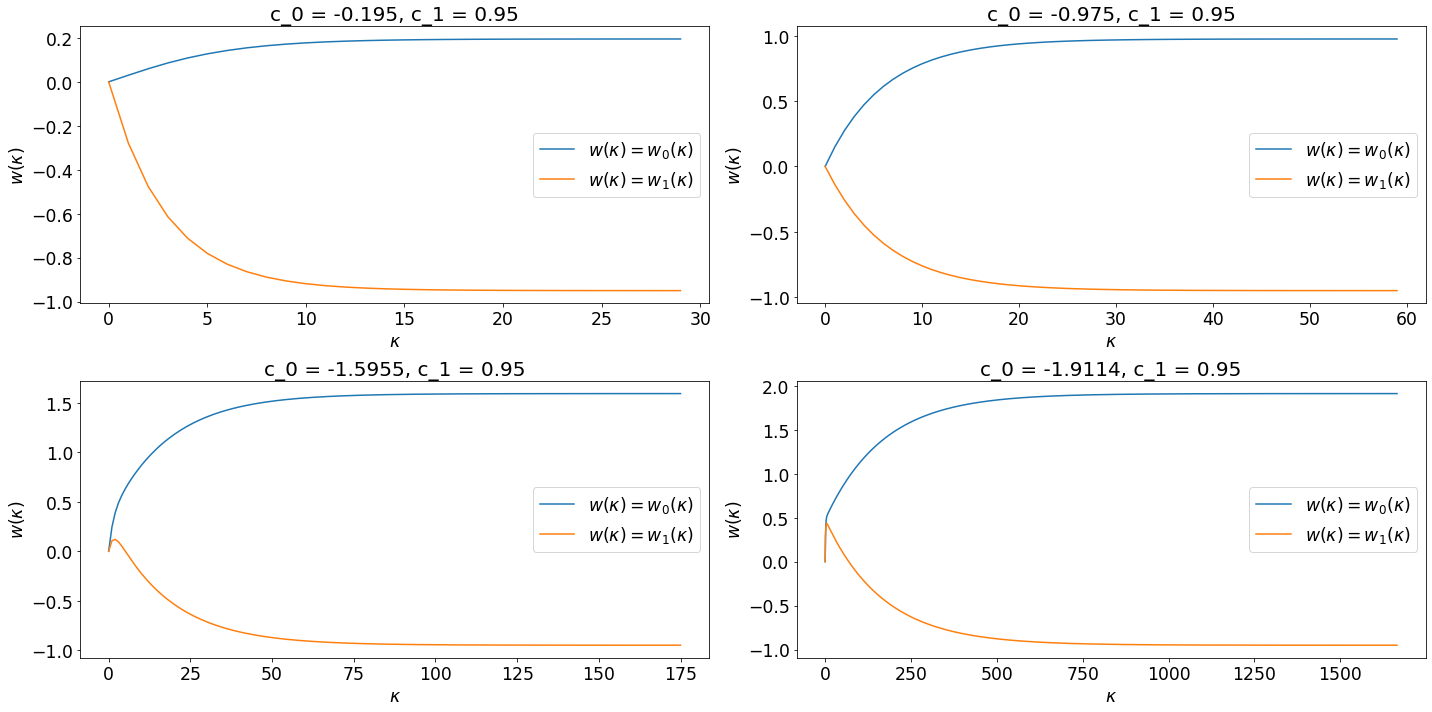

In [55]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for experiment, axis in zip(summary, axes.flatten()):
    axis.plot(experiment['w_history'][:, 0])
    axis.plot(experiment['w_history'][:, 1])
    axis.set_title(f'c_0 = {experiment["c_0"]}, c_1 = {experiment["c_1"]}', fontsize=20)
    axis.set_xlabel(r'$\kappa$')
    axis.set_ylabel(r'$w(\kappa)$')
    axis.legend(r'$w(\kappa)=w_0(\kappa)$ $w(\kappa)=w_1(\kappa)$'.split())
plt.tight_layout()